In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install -U \
  "trl==0.19.0" \
  "datasets>=3.6.0" \
  "transformers>=4.42.0" \
  "accelerate>=0.29.0" \
  "fsspec==2025.3.0" \
  "gcsfs==2025.3.0" \
  "bitsandbytes==0.46.0" \
  "peft"

In [ ]:
import warnings

# 경고 메시지 패턴을 필터링
warnings.filterwarnings(
    "ignore",
    message=r".*torch.utils.checkpoint: the use_reentrant parameter.*",
    category=UserWarning
)
warnings.filterwarnings("ignore", message="None of the inputs have requires_grad=True")
warnings.filterwarnings("ignore", message="Caching is incompatible with gradient checkpointing*")

In [ ]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

reward model

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig, prepare_model_for_kbit_training
from trl import RewardTrainer, RewardConfig
from datasets import Dataset
import pandas as pd
from transformers.modeling_utils import PreTrainedModel
from transformers import AutoConfig

# --------------------------------------------------
# 1. RewardModel 정의 (1D 보상 출력)
# --------------------------------------------------
import torch.nn as nn

class SafeRewardModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.transformer = base_model.model.model
        self.value_head = nn.Linear(base_model.config.hidden_size, 1)

        self.config = base_model.config
        self.is_parallelizable = False
        self.model_parallel = False
        self.device = base_model.device
        self.warnings_issued = {}

    def forward(self, input_ids, attention_mask, **kwargs):
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden = output.last_hidden_state
        last_token = hidden[:, -1, :]
        reward = self.value_head(last_token)  # shape: (B, 1)
        return {"logits": reward}             # ✅ shape: (B, 1), not squeezed



# --------------------------------------------------
# 2. PEFT 모델 로드 및 래핑
# --------------------------------------------------
sft_path = "/content/drive/MyDrive/jeju_ppodpo/jeju_sft"
config = PeftConfig.from_pretrained(sft_path)

base_model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype="auto"
)
base_model = prepare_model_for_kbit_training(base_model)
peft_model = PeftModel.from_pretrained(base_model, sft_path)

# 👉 RewardModel로 감싸기
model = SafeRewardModel(peft_model)

# --------------------------------------------------
# 3. 토크나이저 로드
# --------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(sft_path)
tokenizer.pad_token = tokenizer.eos_token


In [ ]:
# --------------------------------------------------
# 4. 데이터셋 불러오기 및 포맷
# --------------------------------------------------
df_rew = pd.read_csv("/content/drive/MyDrive/jeju_ppodpo/data/df_rew.csv")

def format_reward(row):
    prompt = f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 문장을 표준어로 자연스럽게 바꿔주세요.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{row["dialect"]}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""
    return {
        "prompt": prompt,
        "chosen": row["standard"],
        "rejected": row["rejected"]
    }

reward_data = Dataset.from_pandas(df_rew)
reward_data = reward_data.map(format_reward, remove_columns=list(df_rew.columns))
reward_data = reward_data.train_test_split(test_size=0.1)


In [ ]:
from transformers import EarlyStoppingCallback

# --------------------------------------------------
# 5. RewardTrainer 설정 및 실행
# --------------------------------------------------
reward_args = RewardConfig(
    output_dir="/content/drive/MyDrive/jeju_ppodpo/jeju_reward_temp",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=1e-4,
    warmup_steps=100,
    logging_steps=300,
    eval_strategy="steps",
    eval_steps=300,
    save_steps=600,
    save_total_limit=2,
    bf16=True,
    fp16=False,
    report_to=[],
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

reward_trainer = RewardTrainer(
    model=model,
    args=reward_args,
    train_dataset=reward_data["train"],
    eval_dataset=reward_data["test"],
    processing_class=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

reward_trainer.train()


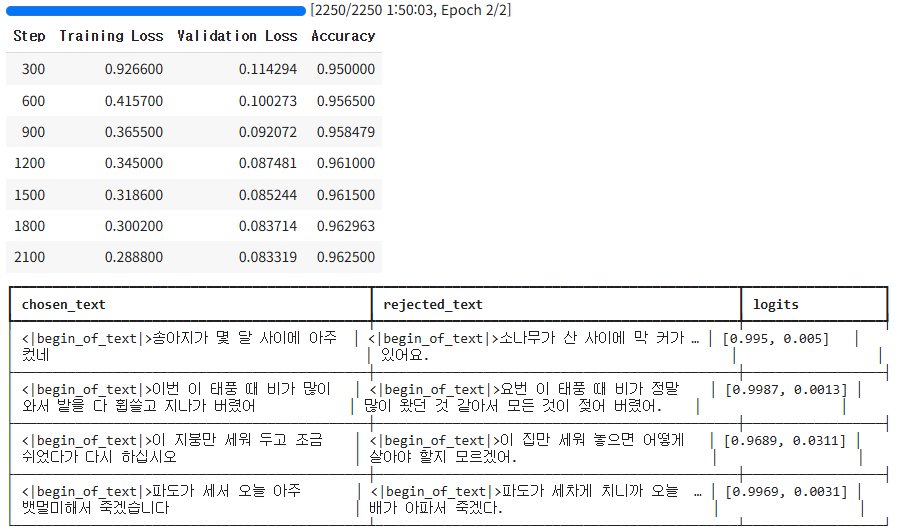

In [ ]:
import torch

save_path = "/content/drive/MyDrive/jeju_ppodpo/jeju_reward"
model_path = f"{save_path}/pytorch_model.bin"

# 디렉토리 없으면 생성
import os
os.makedirs(save_path, exist_ok=True)

# 모델 저장
torch.save(reward_trainer.model.state_dict(), model_path)

# tokenizer 저장 (기존대로)
tokenizer.save_pretrained(save_path)

# 전체 모델 저장
torch.save(reward_trainer.model.state_dict(), os.path.join(reward_save_dir, "model_state_dict.pt"))

# value_head만 따로 저장
torch.save(reward_trainer.model.value_head.state_dict(), os.path.join(reward_save_dir, "value_head.pt"))

ppo rl

In [ ]:
import os
import torch
import copy
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel, PeftConfig, prepare_model_for_kbit_training
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead

# --- 1. 경로 설정 ---
sft_path = "/content/drive/MyDrive/jeju_ppodpo/jeju_sft"
reward_save_dir = "/content/drive/MyDrive/jeju_ppodpo/jeju_reward"
df_rl_path = "/content/drive/MyDrive/jeju_ppodpo/data/df_rl.csv"
ppo_output_dir = "/content/drive/MyDrive/jeju_ppodpo/jeju_ppo"

# --- 2. SFT 기반 PPO 및 Ref 모델 로딩 ---
config = PeftConfig.from_pretrained(sft_path)

def load_peft_model(path):
    base = AutoModelForCausalLM.from_pretrained(
        config.base_model_name_or_path,
        load_in_4bit=True,
        device_map="auto",
        torch_dtype="auto"
    )
    base = prepare_model_for_kbit_training(base)
    return PeftModel.from_pretrained(base, path)

model = load_peft_model(sft_path)        # PPO 학습 모델 (trainable)
ref_model = load_peft_model(sft_path)    # Ref 모델 (고정)
ref_model.eval()

# --- 2-1. Value Model 생성 (SFT, PEFT 없는 베이스에서!)
from transformers import BitsAndBytesConfig
from trl import AutoModelForCausalLMWithValueHead

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

value_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    "Bllossom/llama-3.2-Korean-Bllossom-3B",
    quantization_config=bnb_config,
    device_map="auto"
)

value_model.base_model_prefix = "pretrained_model"
value_model.eval()

if not hasattr(value_model, "score"):
    value_model.score = value_model.v_head


In [ ]:
# --- 3. Reward 모델 정의 및 로딩 ---
class SafeRewardModel(nn.Module):
    def __init__(self, shared_model):
        super().__init__()
        self.transformer = shared_model.model.model  # 공유!
        self.value_head = nn.Linear(shared_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, **kwargs):
        with torch.no_grad():  # transformer는 고정!
            outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden = outputs.last_hidden_state
        reward = self.value_head(hidden[:, -1, :])
        return {"logits": reward}

reward_model = SafeRewardModel(model)
reward_model.value_head.load_state_dict(torch.load(os.path.join(reward_save_dir, "value_head.pt")))
reward_model.eval().to("cuda")
reward_model.base_model_prefix = "transformer"
reward_model.score = reward_model.value_head

# --- 4. Tokenizer 로딩 ---
tokenizer = AutoTokenizer.from_pretrained(sft_path)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# --- 5. PPO 학습 데이터 준비 ---
df_rl = pd.read_csv(df_rl_path)

def build_jeju_ppo_dataset(
    df,
    tokenizer_or_path,
    max_length=128,   # 원하는 최대 길이
    dialect_col="dialect"
):
    if isinstance(tokenizer_or_path, str):
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_or_path)
    else:
        tokenizer = tokenizer_or_path

    tokenizer.pad_token = tokenizer.eos_token
    ds = Dataset.from_pandas(df)

    def build_prompt(row):
        return {
            "review": f"""<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
다음 제주 방언 문장을 표준어로 번역.<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{row[dialect_col]}<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""
        }
    ds = ds.map(build_prompt)

    def tokenize(sample):
        out = tokenizer(
            sample["review"],
            padding="max_length",
            truncation=True,
            max_length=max_length,
        )
        sample["input_ids"] = out["input_ids"]
        sample["query"] = sample["review"]
        return sample

    ds = ds.map(tokenize)
    ds.set_format(type="torch", columns=["input_ids"])
    return ds

ppo_data = build_jeju_ppo_dataset(
    df_rl,
    tokenizer
)
ppo_data = ppo_data.remove_columns(
    [col for col in ppo_data.column_names if col not in ["input_ids", "query"]]
)

In [ ]:
# --- 7. PPOConfig 설정 ---
ppo_config = PPOConfig(
    output_dir="/content/drive/MyDrive/jeju_ppodpo/jeju_ppo_temp",
    learning_rate=5e-5,
    num_train_epochs=1,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=3,
    logging_strategy="steps",
    logging_steps=50,
    logging_dir=f"{ppo_output_dir}/runs",
    remove_unused_columns=False,
    batch_size=1,
    mini_batch_size=4,
    num_ppo_epochs=2,
    kl_coef=0.05,
    cliprange=0.2,
    cliprange_value=0.2,
    vf_coef=0.1,
    gamma=1.0,
    lam=0.95,
    seed=42,
    report_to=["tensorboard"],
    gradient_accumulation_steps=4,
)

# --- 8. PPOTrainer 초기화 및 학습 ---
ppo_trainer = PPOTrainer(
    args=ppo_config,
    model=model,             # PEFT(LoRA) 학습 모델
    ref_model=ref_model,     # PEFT(LoRA) Ref 모델 (고정)
    value_model=value_model, # SFT Base + ValueHead 모델 (PEFT/LORA 적용 X)
    reward_model=reward_model,
    processing_class=tokenizer,
    train_dataset=ppo_data,
    eval_dataset=ppo_data,
)

ppo_trainer.train()

{'eps': 1, 'objective/kl': 356.70782470703125, 'objective/entropy': 307.32171630859375, 'objective/non_score_reward': -17.835391998291016, 'objective/rlhf_reward': -16.6945743560791, 'objective/scores': 1.1408183574676514, 'policy/approxkl_avg': 37.44074249267578, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.0507864952087402, 'val/ratio': 1.6481598615646362, 'val/ratio_var': 4.931743144989014, 'val/num_eos_tokens': 2, 'lr': 8.528784648187634e-07, 'episode': 14784, 'epoch': 0.9856}

{'eps': 1, 'objective/kl': 372.5989074707031, 'objective/entropy': 313.82318115234375, 'objective/non_score_reward': -18.629945755004883, 'objective/rlhf_reward': -18.149696350097656, 'objective/scores': 0.4802500903606415, 'policy/approxkl_avg': 39.293785095214844, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.206024169921875, 'val/ratio': 0.7304035425186157, 'val/ratio_var': 0.40706124901771545, 'val/num_eos_tokens': 1, 'lr': 7.462686567164179e-07, 'episode': 14816, 'epoch': 0.9877333333333334}

{'eps': 1, 'objective/kl': 307.4808349609375, 'objective/entropy': 315.16046142578125, 'objective/non_score_reward': -15.374041557312012, 'objective/rlhf_reward': -14.667394638061523, 'objective/scores': 0.7066468596458435, 'policy/approxkl_avg': 29.88489532470703, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.297147750854492, 'val/ratio': 0.5408617258071899, 'val/ratio_var': 0.0622476264834404, 'val/num_eos_tokens': 3, 'lr': 6.396588486140725e-07, 'episode': 14848, 'epoch': 0.9898666666666667}

{'eps': 1, 'objective/kl': 363.8024597167969, 'objective/entropy': 313.1430969238281, 'objective/non_score_reward': -18.19012451171875, 'objective/rlhf_reward': -17.49216079711914, 'objective/scores': 0.6979646682739258, 'policy/approxkl_avg': 37.99964904785156, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.379453659057617, 'val/ratio': 0.3028341233730316, 'val/ratio_var': 0.015386657789349556, 'val/num_eos_tokens': 2, 'lr': 5.33049040511727e-07, 'episode': 14880, 'epoch': 0.992}

{'eps': 1, 'objective/kl': 351.58880615234375, 'objective/entropy': 339.4829406738281, 'objective/non_score_reward': -17.57944107055664, 'objective/rlhf_reward': -17.038022994995117, 'objective/scores': 0.5414177775382996, 'policy/approxkl_avg': 35.22154998779297, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.3297619819641113, 'val/ratio': 1.470919132232666, 'val/ratio_var': 4.063600540161133, 'val/num_eos_tokens': 1, 'lr': 4.264392324093817e-07, 'episode': 14912, 'epoch': 0.9941333333333333}

{'eps': 1, 'objective/kl': 395.559326171875, 'objective/entropy': 342.13848876953125, 'objective/non_score_reward': -19.777965545654297, 'objective/rlhf_reward': -18.557655334472656, 'objective/scores': 1.2203102111816406, 'policy/approxkl_avg': 41.397674560546875, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.063833236694336, 'val/ratio': 0.7357532978057861, 'val/ratio_var': 0.1595316380262375, 'val/num_eos_tokens': 0, 'lr': 3.1982942430703626e-07, 'episode': 14944, 'epoch': 0.9962666666666666}

{'eps': 1, 'objective/kl': 366.274169921875, 'objective/entropy': 301.0155029296875, 'objective/non_score_reward': -18.313709259033203, 'objective/rlhf_reward': -17.928768157958984, 'objective/scores': 0.38494110107421875, 'policy/approxkl_avg': 38.75564956665039, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 2.931187152862549, 'val/ratio': 5.010801315307617, 'val/ratio_var': 68.01727294921875, 'val/num_eos_tokens': 2, 'lr': 2.1321961620469084e-07, 'episode': 14976, 'epoch': 0.9984}

{'eps': 1, 'objective/kl': 371.8514404296875, 'objective/entropy': 324.53179931640625, 'objective/non_score_reward': -18.592571258544922, 'objective/rlhf_reward': -18.06216812133789, 'objective/scores': 0.5304023027420044, 'policy/approxkl_avg': 38.60491180419922, 'policy/clipfrac_avg': 0.0, 'loss/policy_avg': nan, 'loss/value_avg': nan, 'val/clipfrac_avg': 0.0, 'policy/entropy_avg': 3.1922149658203125, 'val/ratio': 0.4704049825668335, 'val/ratio_var': 0.0759960412979126, 'val/num_eos_tokens': 1, 'lr': 1.0660980810234542e-07, 'episode': 15008, 'epoch': 1.0005333333333333}

In [ ]:
model_save_path = os.path.join(ppo_output_dir, "ppo_policy")
ppo_trainer.model.policy.save_pretrained(model_save_path)

tokenizer.save_pretrained(model_save_path)

value_save_path = os.path.join(ppo_output_dir, "ppo_value")
torch.save(value_model.state_dict(), os.path.join(value_save_path, "pytorch_model.bin"))